<a href="https://colab.research.google.com/github/Efefefef/IANNwTF-UniOsnabrueck/blob/main/Homework03_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

In [33]:
# Visualization function
def visualization(train_losses , train_accuracies , test_losses , test_accuracies):
    plt.figure()
    #testing takes place every 1875th (no of samples/batch size = 60000/32) steps. So we plot them there. 
    #we test once more than we train, so we need one data boint more
    #xtest = np.arange(0,len(train_losses)+1875,1875)
    plt.plot(train_losses , "b-", label = 'training loss')
    line2 , = plt.plot(test_losses , "r-", label = 'test loss') 
    line3 , = plt.plot(train_accuracies , "b:", label = 'train_accuracies')
    line4 , = plt.plot(test_accuracies , "r:", label= 'test_accuracies') 
    plt.xlabel("Training steps")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()

In [34]:
def visualization(train_losses , train_accuracies , test_losses , test_accuracies):
    plt.figure()
    #testing takes place every 1875th (no of samples/batch size = 60000/32) steps. So we plot them there. 
    #we test once more than we train, so we need one data boint more
    xtest = np.arange(0,len(train_losses)+1875,1875)
    line1 , = plt.plot(train_losses , "b-")
    line2 , = plt.plot(xtest, test_losses , "r-") 
    line3 , = plt.plot(train_accuracies , "b:")
    line4 , = plt.plot(xtest, test_accuracies , "r:") 
    plt.xlabel("Training steps")
    plt.ylabel("Loss/Accuracy")
    plt.legend((line1, line2, line3, line4), ("training loss", "test loss", "train accuracy", "test accuracy"))
    plt.show()

In [35]:
def prepare_mnist_data(mnist_data, batch_size):
    mnist_data = mnist_data.map(lambda image, target: (tf.cast(image, tf.float32) / 128. - 1, target))
    mnist_data = mnist_data.map(lambda image, target: (tf.reshape(image, (-1,)), target))
    mnist_data = mnist_data.map(lambda image, target: (image, tf.one_hot(target, 10)))
    mnist_data.cache()
    mnist_data = mnist_data.shuffle(1000)
    mnist_data = mnist_data.batch(batch_size)
    mnist_data = mnist_data.prefetch(tf.data.AUTOTUNE)

    return mnist_data

In [36]:
class MyModel(tf.keras.Model):

    def __init__(self, n_unit):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(n_unit, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(n_unit, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.out(x)
        return x

In [37]:
def train_step(model, input, target, loss_function, optimizer):
    with tf.GradientTape() as tape:
        predictions = model(input)
        loss = loss_function(target, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, predictions

def test(model, image, target, loss_function):
    
    predictions = model(image)
    loss = loss_function(target, predictions)

    return loss, predictions

In [38]:
def train(model, train_ds, test_ds, epochs, loss_function, optimizer, train_losses, train_accuracies, test_losses, test_accuracies):
    
    for epoch in range(epochs):
        train_accuracy_aggregator = []
        test_accuracy_aggregator = []
        #perform a testing step
        #we do one testing step before training to see how good the network is by chance
        losses = []
        for image, target in test_ds:
            loss, test_predictions = test(model, image, target, loss_function)
            losses.append(loss)
            
            sample_test_accuracy = np.mean(np.argmax(test_predictions, axis=1) == np.argmax(target, axis=1))
            test_accuracy_aggregator.append(sample_test_accuracy)
            
        #perform training
        losses = []
        for image, target in train_ds:
            loss, predictions = train_step(model, image, target, loss_function, optimizer)
            losses.append(loss)
            sample_train_accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(target, axis=1))
            train_losses.append(tf.reduce_mean(losses))
            train_accuracy_aggregator.append(np.mean(sample_train_accuracy))
            train_accuracies.append(tf.reduce_mean(train_accuracy_aggregator))
       
        
        #only store mean of loss and accuracy for test steps
        test_losses.append(tf.reduce_mean(losses))         
        test_accuracies.append(tf.reduce_mean(test_accuracy_aggregator))


    #perform one extra test step because we can
    losses = []
    test_accuracy_aggregator = []

    for image, target in test_ds:
        loss, test_predictions = test(model, image, target, loss_function)
        losses.append(loss)
            
        sample_test_accuracy = np.mean(np.argmax(test_predictions, axis=1) == np.argmax(target, axis=1))
        test_accuracy_aggregator.append(sample_test_accuracy)
    test_losses.append(tf.reduce_mean(losses))         
    test_accuracies.append(tf.reduce_mean(test_accuracy_aggregator))

    return train_losses, train_accuracies, test_losses, test_accuracies

In [39]:
num_epochs = 10
learning_rate = 0.1
n_unit = 256
batch_size = 32

model = MyModel(n_unit = n_unit)

(train_ds, test_ds), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

train_losses , train_accuracies , test_losses , test_accuracies = [], [], [], []

train_losses, train_accuracies, test_losses ,test_accuracies = train(
    model = model, 
    train_ds= prepare_mnist_data(train_ds, batch_size), 
    test_ds= prepare_mnist_data(test_ds, batch_size), 
    epochs= num_epochs, 
    loss_function= tf.keras.losses.CategoricalCrossentropy(), 
    optimizer = tf.keras.optimizers.SGD(learning_rate),
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    test_losses=test_losses,
    test_accuracies=test_accuracies
)

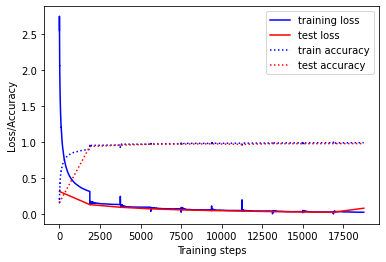

In [40]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

## ADJUSTING HYPERPARAMETERS

Observation is done by changing only one particular parameter, and having the remaining parameters the same as followings:

```
learning_rate = 0.1
n_unit = 256
batch_size = 32
momentum=0.0

```



### 1. Increasing learning rate to 0.8 

In [ ]:
learning_rate = 0.8

train_losses , train_accuracies , test_losses , test_accuracies = [], [], [], []

train_losses, train_accuracies, test_losses ,test_accuracies = train(
    model = model, 
    train_ds= prepare_mnist_data(train_ds, batch_size), 
    test_ds= prepare_mnist_data(test_ds, batch_size), 
    epochs= num_epochs, 
    loss_function= tf.keras.losses.CategoricalCrossentropy(), 
    optimizer = tf.keras.optimizers.SGD(learning_rate),
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    test_losses=test_losses,
    test_accuracies=test_accuracies
)

visualization(train_losses, train_accuracies, test_losses, test_accuracies)

### 2. Increasing and decreasing batch size

In [40]:
# Increasing batch size
learning_rate = 0.1
batch_size = 64

train_losses , train_accuracies , test_losses , test_accuracies = [], [], [], []

train_losses, train_accuracies, test_losses ,test_accuracies = train(
    model = model, 
    train_ds= prepare_mnist_data(train_ds, batch_size), 
    test_ds= prepare_mnist_data(test_ds, batch_size), 
    epochs= num_epochs, 
    loss_function= tf.keras.losses.CategoricalCrossentropy(), 
    optimizer = tf.keras.optimizers.SGD(learning_rate),
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    test_losses=test_losses,
    test_accuracies=test_accuracies
)

visualization(train_losses, train_accuracies, test_losses, test_accuracies)

In [41]:
# Decreasing batch size
learning_rate = 0.1
batch_size = 8

train_losses , train_accuracies , test_losses , test_accuracies = [], [], [], []

train_losses, train_accuracies, test_losses ,test_accuracies = train(
    model = model, 
    train_ds= prepare_mnist_data(train_ds, batch_size), 
    test_ds= prepare_mnist_data(test_ds, batch_size), 
    epochs= num_epochs, 
    loss_function= tf.keras.losses.CategoricalCrossentropy(), 
    optimizer = tf.keras.optimizers.SGD(learning_rate),
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    test_losses=test_losses,
    test_accuracies=test_accuracies
)

visualization(train_losses, train_accuracies, test_losses, test_accuracies)

### 3. Increasing n-unit in layer

In [ ]:
learning_rate = 0.1
n_unit = 512
batch_size = 32

train_losses , train_accuracies , test_losses , test_accuracies = [], [], [], []

train_losses, train_accuracies, test_losses ,test_accuracies = train(
    model = model, 
    train_ds= prepare_mnist_data(train_ds, batch_size), 
    test_ds= prepare_mnist_data(test_ds, batch_size), 
    epochs= num_epochs, 
    loss_function= tf.keras.losses.CategoricalCrossentropy(), 
    optimizer = tf.keras.optimizers.SGD(learning_rate),
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    test_losses=test_losses,
    test_accuracies=test_accuracies
)

visualization(train_losses, train_accuracies, test_losses, test_accuracies)

### Increasing momentum

In [ ]:
learning_rate = 0.1
n_unit = 512
batch_size = 32
momentum = 0.9

train_losses , train_accuracies , test_losses , test_accuracies = [], [], [], []

train_losses, train_accuracies, test_losses ,test_accuracies = train(
    model = model, 
    train_ds= prepare_mnist_data(train_ds, batch_size), 
    test_ds= prepare_mnist_data(test_ds, batch_size), 
    epochs= num_epochs, 
    loss_function= tf.keras.losses.CategoricalCrossentropy(), 
    optimizer = tf.keras.optimizers.SGD(learning_rate),
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    test_losses=test_losses,
    test_accuracies=test_accuracies
)

visualization(train_losses, train_accuracies, test_losses, test_accuracies)